<a href="https://colab.research.google.com/github/marcusborela/Aprendizado-Profundo-Unicamp/blob/main/classificandoImagensdeSatelite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensaio de classificação de imagens de satélite Sentinel 2

Remis Balaniuk, PhD

Nesse caderno abordaremos as principais etapas e tarefas necessárias para implementar e treinar um rede convolucional na tarefa de classificação de imagens de satélite multi espectrais.


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install rasterio
!pip install gputil
!pip install psutil
!pip install humanize
!pip install simplekml
import simplekml
import psutil
import humanize
import GPUtil as GPU
import rasterio
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import gc
import glob
import pickle as pi
import re
import math
from random import shuffle
import gdal
import os
from tempfile import NamedTemporaryFile
import h5py
import sys
from tqdm import tqdm
import itertools
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from google.colab import drive
from IPython.display import IFrame


drive.mount('/content/drive/')

%matplotlib inline

rseed = 100
np.random.seed(rseed)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached rasterio-1.2.10-cp37-cp37m-manylinux1_x86_64.whl (19.3 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached simplekml-1.3.6-py3-none-any.whl
Mounted at /content/drive/


# Organização dos dados

Vamos assumir que as imagens estão separadas em subdiretórios, um para cada classe.

Posicione-se no seu diretório de diretórios de imagens.



In [ ]:
%pwd

'/content'

In [ ]:
%cd /content/drive/MyDrive/DataForTailingDamDetection/Data/SentinelMinesDams/train/

/content/drive/.shortcut-targets-by-id/1aIK9Gf7J0xpdioKfUv6YsB1Br4r2vNYp/DataForTailingDamDetection/Data/SentinelMinesDams/train


In [ ]:
%ls

mine/              notmine/         trainingDataAvgStd.npz
modelMetaData.npz  testingData.npz  trainingData.npz


In [ ]:
char_labels = []
for label_num, subdir in enumerate(next(os.walk('./'))[1]):
    char_labels.append(subdir)


In [ ]:
char_labels

['mine', 'notmine']

In [ ]:
n_imagens = 0

for subdir in char_labels:
  n_imagens += len(os.listdir(subdir))

In [ ]:
n_imagens

2860

## Definições iniciais:

As imagens podem ter pequenas variações em número de pixels. Vamos estabelecer um tamanho padrão e adequar as imagens.

Sentinel-2 Bands	Central Wavelength (µm)	Resolution (m)
- Band 1 - Coastal aerosol	0.443	60 umidade
- Band 2 - Blue	0.490	10
- Band 3 - Green	0.560	10
- Band 4 - Red	0.665	10
- Band 5 - Vegetation Red Edge	0.705	20  
- Band 6 - Vegetation Red Edge	0.740	20
- Band 7 - Vegetation Red Edge	0.783	20
- Band 8 - NIR	0.842	10 infravermelho próximo (NEXT)
- Band 8A - Vegetation Red Edge	0.865	20
- Band 9 - Water vapour	0.945	60
- Band 10 - SWIR - Cirrus	1.375	60
- Band 11 - SWIR	1.610	20  Infra distante
- Band 12 - SWIR	2.190	20  Infra distante

In [ ]:
image_width = 200
image_height = 200

Nbands = 7

# este script assume que estamos usando imagens do Sentinel 2 com 12 spectral bands mas selecionaremos só 10 
#opt_string = '-outsize {} {} -b 2 -b 3 -b 4 -b 5 -b 6 -b 7 -b 8 -b 8A -b 11 -b 12'.format(image_height, image_width)

# qdo extraiu do google earth, pediu pra pixel ser de 10mts
# mesmo bandas com pixels maiores foram subdivididos: copia e cola
# este script assume que estamos usando imagens do Sentinel 2 com 12 spectral bands mas selecionaremos só 7 por limitações de memória 
opt_string = '-outsize {} {} -b 2 -b 3 -b 4 -b 5 -b 7 -b 8 -b 11'.format(image_height, image_width)


# quantas classes?
n_classes = 2

## Definindo os arrays para as imagens a priori para evitar variações de tamanho nos dados.

In [ ]:
# del imagens
# del labels

In [ ]:
imagens = np.zeros((n_imagens, image_width, image_height, Nbands), dtype=np.float32)
labels = -1 * np.ones((n_imagens,), dtype=np.int64)


## Carregando as imagens

Para carregar e pré processar as imagens geoespaciais precisaremos usar uma biblioteca especializada chamada GDAL - Geospatial Data Abstraction Library https://gdal.org/api/python.html.

É possível que a memória da VM do Colab não suporte um volume muito grande de imagens. 

In [ ]:
image_counter = 0
for i in range(len(char_labels)):

  subdir = char_labels[i]
  print("Carregando imagens para classe", subdir)

  files = np.array(os.listdir(subdir))
  # fazendo permutação para evitar vies
  permutation = np.random.permutation(len(files))
  files = files[permutation]
  
  for file in files:
      img_dataset = gdal.Translate(NamedTemporaryFile(delete=False).name,
                                    gdal.Open(subdir + '/' + file, gdal.GA_ReadOnly),
                                    options=opt_string)

      # queremos 200x200 e os canais um atrás do outro
      img_array = np.transpose(np.array(img_dataset.ReadAsArray(),dtype = 'float32'), axes=(1, 2, 0))

      linhas = min(image_height,img_array.shape[0])
      colunas = min(image_height,img_array.shape[1])

      imagens[image_counter, :linhas, :colunas, :] = img_array[:linhas,:colunas,0:Nbands]
      labels[image_counter] = i
      image_counter += 1


## Salvando as imagens em formato numpy 

Caso a VM caia...

In [ ]:
%cd  /content/drive/MyDrive/curso_analise_imagens_satelite/minas

In [ ]:
%pwd

In [ ]:
np.savez('./imagens',
            images=imagens,
            labels=labels,
            charlabels = char_labels)

# Separando em conjuntos de treinamento e teste

In [ ]:
# defina aqui o percentual a ser usado no treinamento
split_ratio = 0.8

permutation = np.random.permutation(n_imagens)
imagens = imagens[permutation]
labels = labels[permutation]

Ntrain = int(n_imagens*split_ratio)

train_images = imagens[:Ntrain] 
train_labels = labels[:Ntrain] 

test_images = imagens[Ntrain:]
test_labels = labels[Ntrain:]

## Normalizando os dados


In [ ]:
nmean = np.zeros(Nbands)
nmax = np.zeros(Nbands)

# Normalizando pixels usando z-score
for i in range(Nbands):
  nmean[i] = np.mean(train_images[:,:,:,i])  # média 
  nmax[i] = np.std(train_images[:,:,:,i])    # desvio padrão
  train_images[:,:,:,i]=train_images[:,:,:,i]-nmean[i]
  train_images[:,:,:,i]=train_images[:,:,:,i]/nmax[i]
  test_images[:,:,:,i]=test_images[:,:,:,i]-nmean[i]
  test_images[:,:,:,i]=test_images[:,:,:,i]/nmax[i]



## Salvando dados de treinamento pré processados para carga mais rápida.

Salvareremos também a média e o desvio padrão estimados na base de treinamento para uso posterior no pré processamento da base de teste.

Posicione-se num diretório no qual você possa salvar dados do experimento. Tipicamente você vai realizar diversos experimentos, com diferentes configurações e arquiteturas, por isso é interessante deixar pastas separadas para cada um.

In [ ]:
np.savez('./trainingData',
            images=train_images,
            labels=train_labels,
            charlabels = char_labels)

np.savez('./testingData',
            images=test_images,
            labels=test_labels,
            charlabels = char_labels)

np.savez('./modelMetaData',
            metadata =np.array([image_width,image_height,Nbands,n_classes,char_labels])) 

np.savez('./trainingDataAvgStd',
            median=nmean,
            std=nmax)

## Carregando datasets pré-processados de arquivo

Só execute se for recomeçar desse ponto.

In [ ]:
model_path = '/content/drive/MyDrive/curso_analise_imagens_satelite/minas'

In [ ]:
%cd '/content/drive/MyDrive/curso_analise_imagens_satelite/minas'

/content/drive/MyDrive/curso_analise_imagens_satelite/minas


In [ ]:
npzfile = np.load('./trainingData.npz')
train_images =     npzfile['images']
train_labels =     npzfile['labels']
char_labels =      npzfile['charlabels']

npzfile = np.load('./testingData.npz')
test_images =     npzfile['images']
test_labels =     npzfile['labels']
char_labels =      npzfile['charlabels']

n_images = train_images.shape[0] + test_images.shape[0]
metadata = np.load('./modelMetaData.npz',allow_pickle=True)
image_width,image_height,Nbands,n_classes,char_labels = metadata['metadata'] 

# os dados de treinamento foram salvos já normalizados
npzfile = np.load('./trainingDataAvgStd.npz',)
nmean = npzfile['median']
nmax = npzfile['std']


In [ ]:
test_images.shape

(572, 200, 200, 7)

# Definindo a arquitetura da rede

In [ ]:
def tf_cross_entropy_with_logits(y_true, y_pred):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))

def custom_sparse_categorical_accuracy(y_true,y_pred):
  sh=tf.shape(y_pred)
  y_pred = tf.reshape(y_pred, [sh[0]*sh[1],n_classes])   # adjust the last argument for the number of classes 
  y_true = tf.reshape(y_true, [sh[0]*sh[1],1])
  
  return tf.keras.metrics.sparse_categorical_accuracy(y_true,y_pred)

def custom_sparse_categorical_crossentropy(y_true,y_pred):
  sh=tf.shape(y_pred)
  y_pred = tf.reshape(y_pred, [sh[0]*sh[1],n_classes]) # adjust the last argument for the number of classes 
  y_true = tf.reshape(y_true, [sh[0]*sh[1],1])
 
  return tf.keras.losses.sparse_categorical_crossentropy(y_true,y_pred)


In [ ]:
def define_FCN_discovery(image_width,image_height,Nbands):

  #global n_classes
  #n_classes = nc
  kx = math.ceil((image_width-32)/27)  
  ky = math.ceil((image_height-32)/27)  
  # define the Fully Convolution Neural Network
  input=layers.Input(shape=(None, None, Nbands))
  x0=layers.Conv2D(32, (3, 3), (1,1), activation='relu', padding='SAME')(input)
  x1=layers.MaxPooling2D((3, 3))(x0)
  x2=layers.Conv2D(64, (3, 3), (1,1), activation='relu', padding='SAME')(x1)
  x3=layers.MaxPooling2D((3, 3))(x2)
  x4=layers.Conv2D(64, (3, 3), (1,1), activation='relu', padding='SAME')(x3)
  x5=layers.MaxPooling2D((3,3))(x4)
  x6=layers.Conv2D(64, (kx,ky), (1,1), activation = 'relu')(x5)  # the convolution kernel size must be adapted for image size 
  x7=layers.Dropout(0.5)(x6)
  x8=layers.Conv2D(n_classes, (1,1), (1,1), padding='VALID', activation='softmax')(x7)
  model=models.Model(input,x8)
  model.summary()

  model.compile(optimizer='adam',
              loss=custom_sparse_categorical_crossentropy,
              metrics=[custom_sparse_categorical_accuracy])
             
  return model

  # rede fica puramente convolucional, menor
  # sem flatten e sem  fully connected


In [ ]:
model = define_FCN_discovery(image_width,image_height,Nbands)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 7)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    2048      
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 32)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 64)   0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 64)    36928 

## Treinando a CNN

In [ ]:
# Criando um callback  que salve os pesos do modelo
  
epochs = 20
batchsize = 5 # cuidado com o tamanho para não derrubar a máquina

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath= './trained_model/weights.ckpt',
                                                save_weights_only=True,
                                                verbose=1)


In [ ]:

fit = model.fit(train_images, train_labels, epochs=epochs, batch_size=batchsize,callbacks=[cp_callback])

accuracy = fit.history[list(fit.history.keys())[-1]]


Epoch 1/20
458/458 [==============================] - ETA: 0s - loss: 0.4544 - custom_sparse_categorical_accuracy: 0.8182
Epoch 1: saving model to ./trained_model/weights.ckpt
458/458 [==============================] - 16s 8ms/step - loss: 0.4544 - custom_sparse_categorical_accuracy: 0.8182
Epoch 2/20
455/458 [============================>.] - ETA: 0s - loss: 0.2637 - custom_sparse_categorical_accuracy: 0.8989
Epoch 2: saving model to ./trained_model/weights.ckpt
458/458 [==============================] - 4s 8ms/step - loss: 0.2627 - custom_sparse_categorical_accuracy: 0.8990
Epoch 3/20
456/458 [============================>.] - ETA: 0s - loss: 0.2225 - custom_sparse_categorical_accuracy: 0.9154
Epoch 3: saving model to ./trained_model/weights.ckpt
458/458 [==============================] - 4s 8ms/step - loss: 0.2221 - custom_sparse_categorical_accuracy: 0.9156
Epoch 4/20
455/458 [============================>.] - ETA: 0s - loss: 0.1886 - custom_sparse_categorical_accuracy: 0.9345
Epoc

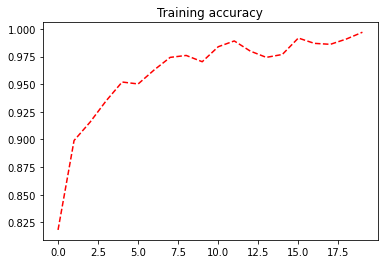

In [ ]:

plt.plot(range(epochs), accuracy, 'r--', label='train')
plt.title('Training accuracy')
plt.show()

## Carregando um model salvo

In [ ]:
%cd  '/content/drive/MyDrive/curso_analise_imagens_satelite/minas'

/content/drive/MyDrive/curso_analise_imagens_satelite/minas


In [ ]:
if os.path.exists('./trained_model/checkpoint'): 
  metadata = np.load('./modelMetaData.npz',allow_pickle=True)
  image_width,image_height,Nbands,n_classes,char_labels = metadata['metadata'] 

  model = define_FCN_discovery(image_width,image_height,Nbands)
  
  model.load_weights('./trained_model/weights.ckpt')
    
  npzfile = np.load('./trainingDataAvgStd.npz',)
  nmean = npzfile['median']
  nmax = npzfile['std']

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 7)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    2048      
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 32)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 64)   0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 64)    36928 

## Testando o modelo 

In [ ]:
prediction = model.predict(train_images)



In [ ]:

predics = np.zeros(len(prediction))

predics = prediction[:,0,0,:].argmax(axis=1) 

print(confusion_matrix(train_labels, predics))


[[1114    1]
 [   1 1172]]


In [ ]:
# testing
print("Testing:")
prediction = model.predict(test_images)

predics = np.zeros(len(prediction))

predics = prediction[:,0,0,:].argmax(axis=1) 

print(confusion_matrix(test_labels, predics))

y_true = test_labels
y_pred = predics

if n_classes==2:
  print("Precision: ", metrics.precision_score(y_true, y_pred))
  print("Recall: ", metrics.recall_score(y_true, y_pred))
  print("F1 score: ", metrics.f1_score(y_true, y_pred))
  print("Mean accuracy: ", metrics.accuracy_score(y_true, y_pred))
  print("AUC: ", metrics.roc_auc_score(y_true, y_pred))
  print("mcc: ", metrics.matthews_corrcoef(y_true, y_pred))
  print("kappa: ", metrics.cohen_kappa_score(y_true, y_pred))


Testing:
[[274   8]
 [  6 284]]
Precision:  0.9726027397260274
Recall:  0.9793103448275862
F1 score:  0.9759450171821304
Mean accuracy:  0.9755244755244755
AUC:  0.9754707752506725
mcc:  0.9510578522874463
kappa:  0.9510345839651715


# Aplicando o modelo em grandes imagens

In [ ]:
def predict(modelo,labels,experiment_name,image_width,
            image_height,nmean,nmax,Nbands,
            path_to_predict_images,path_to_results,
            slicing = 1):

  """
    path_to_predict_images: onde ficam os rasters das imagens
    slicing: parâmetro que diz em quantos pedaços quebrar
      1, pega imagem inteira
      2: divide em 4 blocos
  """
  countImages = 0
  
  print("Escolha a classe alvo: ")
  for i in range(0, len(labels)):
    print(i,":",labels[i])
  try:
    save=int(input('Input:'))
  except ValueError:
    print("Not a number")

  kmlFull=simplekml.Kml()
  resultsFull = [] 

  # processa cada imagem no diretório de predição
  for file in os.listdir(path_to_predict_images):
    print(path_to_predict_images + file)

    starthere = len(resultsFull)
    
    # gdal lê o tiff
    testimage = gdal.Translate(NamedTemporaryFile(delete=False).name,
                                  gdal.Open(path_to_predict_images + file, gdal.GA_ReadOnly),
                                  options = '-b 2 -b 3 -b 4 -b 5 -b 7 -b 8 -b 11')           # use as mesmas bandas

    print("imagem carregada")
    testimage = np.transpose(np.array(testimage.ReadAsArray(),dtype = 'float32'), axes=(1, 2, 0))
    testimage = testimage[:,:,0:Nbands]
    for i in range(Nbands):
      testimage[:,:,i]=testimage[:,:,i]-nmean[i]
      testimage[:,:,i]=testimage[:,:,i]/nmax[i]

    # corta a imagem para previsão se for muito grande para o colab. 
    # divide a imagem em patches regulares 2D 
    # Adapte o "slicing" ao seu tamanho de imagem e disponibilidade de memória no colab  
    
    sh = np.array(testimage.shape)
    sh[0] = sh[0]//slicing
    sh[1] = sh[1]//slicing
    prediction = None

    print("imagem processada")

    for i in range(0,slicing):  
      for j in range(0,slicing):
        patch = np.expand_dims(testimage[sh[0]*i:sh[0]*(i+1),sh[1]*j:sh[1]*(j+1),:],axis=0) 
        # compute prediction of the FCN
        if prediction is None:
          prediction = model.predict(patch)
        else:
          prediction = np.append(prediction,model.predict(patch), axis=0)
      
    # locate the predictions on the patches

    shp = prediction.shape
    results = []
    lpatches = []
    kml=simplekml.Kml()
    count_positives = 0

    with rasterio.open(path_to_predict_images+file) as map_layer:
      for i in range(0,slicing):  
        for j in range(0,slicing): 
 
          print('slice:',i,j)
          pos = i*slicing+j
          
          pred_classes = tf.greater(prediction[pos,:,:,save],0.6) # considerando um limite de probabilidade de 60% para aceitar um resultado
          shpc = tf.shape(pred_classes)

          inds = tf.where(pred_classes==True)

          # recalculando a posição para a dimensão original da imagem
          # gera mapas menores
          xloc = i*sh[0]+np.array(tf.gather(np.linspace(image_width/2.0,sh[0]-image_width/2.0,num=shpc[0]),inds[:,0]))
          yloc = j*sh[1]+np.array(tf.gather(np.linspace(image_height/2.0,sh[1]-image_height/2.0,num=shpc[1]),inds[:,1]))
          predloc = prediction[pos,inds[:,0],inds[:,1],save]

          for k in range(0,len(xloc)):
            pixels2coords = map_layer.xy(xloc[k] , yloc[k]) 

            r = np.ones(4)*-1      
            
            r[0] = pixels2coords[0]
            r[1] = pixels2coords[1]
            r[2] = predloc[k]

            tag = labels[save]
              
            kml.newpoint(name=tag, coords=[(pixels2coords[0],pixels2coords[1])])
            kmlFull.newpoint(name=tag, coords=[(pixels2coords[0],pixels2coords[1])])

            results.append(r)
            resultsFull.append(r)

    # save prediction files to the results folder
    np.savetxt(path_to_results + 'prediction_{}.csv'.format(file), results, delimiter=",")
    kml.save(path_to_results + 'predictions_{}.kml'.format(file))  

    countImages+=1

    del testimage
    del patch
    del prediction
    del results
    del kml
    gc.collect()

  np.savetxt(path_to_results + 'prediction_{}.csv'.format(experiment_name), np.array(resultsFull), delimiter=",")
  kmlFull.save(path_to_results + 'predictions_{}.kml'.format(experiment_name))  


## Ajuste os diretórios

In [31]:
path_to_results =   '/content/drive/MyDrive/curso_analise_imagens_satelite/minas/'
path_to_predict_images = '/content/drive/MyDrive/DataForTailingDamDetection/Data/SentinelMinesDams/predict/'

predict(model,char_labels,'minas',image_width,image_height,nmean,nmax,Nbands,path_to_predict_images,path_to_results,slicing=10)

Escolha a classe alvo: 
0 : mine
1 : notmine
Input:0
/content/drive/MyDrive/DataForTailingDamDetection/Data/SentinelMinesDams/predict/retanguloMGSAR-0000000000-0000018432.tif
imagem carregada
imagem processada
slice: 0 0
slice: 0 1
slice: 0 2
slice: 0 3
slice: 0 4
slice: 0 5
slice: 0 6
slice: 0 7
slice: 0 8
slice: 0 9
slice: 1 0
slice: 1 1
slice: 1 2
slice: 1 3
slice: 1 4
slice: 1 5
slice: 1 6
slice: 1 7
slice: 1 8
slice: 1 9
slice: 2 0
slice: 2 1
slice: 2 2
slice: 2 3
slice: 2 4
slice: 2 5
slice: 2 6
slice: 2 7
slice: 2 8
slice: 2 9
slice: 3 0
slice: 3 1
slice: 3 2
slice: 3 3
slice: 3 4
slice: 3 5
slice: 3 6
slice: 3 7
slice: 3 8
slice: 3 9
slice: 4 0
slice: 4 1
slice: 4 2
slice: 4 3
slice: 4 4
slice: 4 5
slice: 4 6
slice: 4 7
slice: 4 8
slice: 4 9
slice: 5 0
slice: 5 1
slice: 5 2
slice: 5 3
slice: 5 4
slice: 5 5
slice: 5 6
slice: 5 7
slice: 5 8
slice: 5 9
slice: 6 0
slice: 6 1
slice: 6 2
slice: 6 3
slice: 6 4
slice: 6 5
slice: 6 6
slice: 6 7
slice: 6 8
slice: 6 9
slice: 7 0
slice: 7 

## A previsão gera arquivos csv e kml com coordenadas dos pontos encontrados